In [1]:
#==================================================================================
# Question & Answer 훈련 예제
#
# => input_ids : [CLS]질문[SEP]지문[SEP]
# => attention_mask : 1111111111(질문, 지문 모두 1)
# => token_type_ids : 0000000(질문)1111111(지문)
# => start_positions : 45 (질문에 대한 지문에서의 답변 시작 위치)
# => end_positions : 60 (질문에 대한 지문에서의 답변 끝 위치)
#==================================================================================

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import os
import sys
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering, AdamW, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm

sys.path.append('..')
from myutils import seed_everything, GPU_info, mlogging, QADataset

logger = mlogging(loggername="bertQAtrain", logfilname="bertQAtrain")
device = GPU_info()
seed_everything(111)

logfilepath:bwdataset_2022-03-16.log
logfilepath:qnadataset_2022-03-16.log
logfilepath:bertQAtrain_2022-03-16.log
True
device: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA A30


In [2]:
#############################################################################################
# 변수들 설정
# - model_path : from_pretrained() 로 호출하는 경우에는 모델파일이 있는 폴더 경로나 
#          huggingface에 등록된 모델명(예:'bert-base-multilingual-cased')
#          torch.load(model)로 로딩하는 경우에는 모델 파일 풀 경로
#
# - vocab_path : from_pretrained() 호출하는 경우에는 모델파일이 있는 폴더 경로나
#          huggingface에 등록된 모델명(예:'bert-base-multilingual-cased')   
#          BertTokenizer() 로 호출하는 경우에는 vocab.txt 파일 풀 경로,
#
# - OUTPATH : 출력 모델, vocab 저장할 폴더 경로
#############################################################################################

model_path = '../model/distilbert/distilbert-fpt-wiki_20190620-mecab-model-0313'
vocab_path = '../model/distilbert/distilbert-fpt-wiki_20190620-mecab-model-0313'
OUTPATH = '../model/distilbert/distilbert-fpt-wiki_20190620-mecab-model-0313-QA-0315/'

# tokeniaer 및 model 설정
#tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# strip_accents=False : True로 하면, 가자 => ㄱ ㅏ ㅈ ㅏ 식으로 토큰화 되어 버림(*따라서 한국어에서는 반드시 False)
# do_lower_case=False : # 소문자 입력 사용 안함(한국어에서는 반드시 False)
tokenizer = DistilBertTokenizer.from_pretrained(vocab_path, strip_accents=False, do_lower_case=False) 
   
model = DistilBertForQuestionAnswering.from_pretrained(model_path)

model.to(device)

Some weights of the model checkpoint at ../model/distilbert/distilbert-fpt-wiki_20190620-mecab-model-0313 were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at ../model/distilbert/distilbert-fpt-wiki_20190620-mecab-model-0313 and are newly initi

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(143772, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
           

In [3]:
model.num_parameters()

153340418

In [5]:
# 학습 data loader 생성
sys.path.append('..')
from myutils import KorQuADCorpus, QADataset, data_collator
from torch.utils.data import DataLoader, RandomSampler

#############################################################################
# 변수 설정
#############################################################################
max_seq_len = 128   # 질문 + 지문 최대 크기
max_query_length = 32  # 질문 최대 크기
doc_stride = 64     # 지문이 128을 넘을 경우, 얼만큼씩 다음 지문으로 대체할지

batch_size = 32        # 배치 사이즈(64면 GUP Memory 오류 나므로, 32 이하로 설정할것=>max_seq_length 를 줄이면, 64도 가능함)
cache = True   # 캐쉬파일 생성할거면 True로 
#############################################################################

# corpus 파일 설정
corpus = KorQuADCorpus()


# 학습 dataset 생성
print('create train_loader===========================================================')
train_file_fpath = '../korpora/korQuAD/KorQuAD_v1.0_train.json'
train_dataset = QADataset(file_fpath=train_file_fpath, tokenizer=tokenizer, corpus=corpus, max_seq_length=max_seq_len, max_query_length = max_query_length, doc_stride= doc_stride, overwrite_cache=cache)


# 학습 dataloader 생성
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          #shuffle=True, # dataset을 섞음
                          sampler=RandomSampler(train_dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          collate_fn=data_collator, # dataset을 tensor로 변환(예시 {'input_ids':tensor[0,1,2,3,1,], 'token_type_id:tensor[0,0,0,0,0], 'attention_mask:tensor[1,1,1,1,1], 'labels':tensor[5]}
                          num_workers=4)

print('end train_loader===========================================================')

print('create eval_loader===========================================================')
eval_file_fpath = '../korpora/korQuAD/KorQuAD_v1.0_dev.json'
eval_dataset = QADataset(file_fpath=eval_file_fpath, tokenizer=tokenizer, corpus=corpus, max_seq_length=max_seq_len, max_query_length = max_query_length, doc_stride= doc_stride, overwrite_cache=cache)


# 평가 dataloader 생성
eval_loader = DataLoader(eval_dataset, 
                          batch_size=batch_size, 
                          #shuffle=True, # dataset을 섞음
                          sampler=RandomSampler(eval_dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          collate_fn=data_collator, # dataset을 tensor로 변환(예시 {'input_ids':tensor[0,1,2,3,1,], 'token_type_id:tensor[0,0,0,0,0], 'attention_mask:tensor[1,1,1,1,1], 'labels':tensor[5]}
                          num_workers=4)
print('end eval_loader===========================================================')

print('train_loader_len: {}, eval_loader_len: {}'.format(len(train_loader), len(eval_loader)))

2022-03-16 09:30:25,327 - qnadataset - INFO - Creating features from dataset file at ../korpora/korQuAD/KorQuAD_v1.0_train.json


create train_loader===========================================================


100%|████████████████████████████████████| 1420/1420 [00:00<00:00, 19789.84it/s]
convert squad examples to features: 100%|█| 57688/57688 [01:13<00:00, 779.91it/s
2022-03-16 09:31:40,534 - qnadataset - INFO - *** Example ***
2022-03-16 09:31:40,536 - qnadataset - INFO - question & context: [CLS] 바그너 ##는 괴테 ##의 파우스트 ##를 읽 ##고 무엇 ##을 쓰 ##고 ##자 했 ##는 ##가 ? [SEP] 1839 ##년 바그너 ##는 괴테 ##의 파우스트 ##을 처음 읽 ##고 그 내용 ##에 마음 ##이 끌려 이를 소재 ##로 해서 하나의 교향곡 ##을 쓰 ##려 ##는 뜻 ##을 갖 ##는다 . 이 시기 바그너 ##는 1838 ##년에 빛 독 ##촉 ##으로 산전 ##수 ##전을 다 [UNK] 상황 ##이 ##라 좌절 ##과 실망 ##에 가득 ##했으며 메 ##피스 ##토 ##펠 ##레스 ##를 만나 ##는 파우스트 ##의 심경 ##에 공감 ##했다 ##고 한다 . 또한 파리 ##에서 아브 ##네 ##크 ##의 지휘 ##로 파리 음악원 관현악단 ##이 연주 ##하는 베토벤 ##의 교향곡 9 ##번 ##을 듣 ##고 깊 ##은 감명 ##을 받 ##았 ##는데 , 이것 ##이 이듬해 1월 [SEP]
2022-03-16 09:31:40,537 - qnadataset - INFO - answer: 교향곡
2022-03-16 09:31:40,539 - qnadataset - INFO - features: QAFeatures(input_ids=[101, 131787, 11018, 143664, 10459, 141463, 11513, 9642, 11664, 120950, 10622, 9511, 11664, 13764, 9965, 110

end train_loader===========================================================
create eval_loader===========================================================


convert squad examples to features: 100%|██| 5533/5533 [00:06<00:00, 796.54it/s]
2022-03-16 09:32:04,838 - qnadataset - INFO - *** Example ***
2022-03-16 09:32:04,840 - qnadataset - INFO - question & context: [CLS] 1989년 6월 30일 평양 ##축 ##전에 대표 ##로 파견 된 인물 ##은 ? [SEP] 1989년 2월 15일 여의도 농민 폭력 시위 ##를 주도 ##한 혐의 ( 폭력 ##행위 ##등 ##처 ##벌 ##에 ##관 ##한 ##법 ##률 ##위 ##반 ) 으로 지명 ##수 ##배 ##되었다 . 1989년 3월 12일 서울 ##지 ##방 ##검 ##찰청 공안 ##부는 임종 ##석 ##의 사전 ##구 ##속 ##영 ##장을 발부 ##받 ##았다 . 같은 해 6월 30일 평양 ##축 ##전에 임수 ##경 ##을 대표 ##로 파견 ##하여 국가 ##보 ##안 ##법 ##위 ##반 혐의 ##가 추가 ##되었다 . 경찰 ##은 12월 18일 ~ 20일 사이 서울 경희대 ##학교 ##에서 임종 ##석 ##이 성명 발표 ##를 추진 ##하고 있다는 첩보 ##를 입수 ##했고 , 12월 18일 오전 7 ##시 40 ##분 경 가스 [SEP]
2022-03-16 09:32:04,842 - qnadataset - INFO - answer: 임수 ##경
2022-03-16 09:32:04,843 - qnadataset - INFO - features: QAFeatures(input_ids=[101, 76485, 17253, 40636, 121340, 70122, 68767, 119597, 11261, 120811, 9099, 119664, 10892, 136, 102, 76485, 17520, 37912, 127473, 122083, 121735, 120889, 11513, 120495, 11102, 

end eval_loader===========================================================
train_loader_len: 6478, eval_loader_len: 653


In [6]:
# tokenier 테스트
print(len(tokenizer))
print(tokenizer.encode("눈에 보이는 반전이었지만 영화의 흡인력은 사라지지 않았다", "정말 재미있다"))
print(tokenizer.convert_ids_to_tokens(131027))
print(tokenizer.convert_tokens_to_ids('정말'))

143772
[101, 9034, 10530, 119728, 11018, 128441, 10739, 69708, 42428, 10459, 10020, 12030, 28143, 10892, 124227, 12508, 49137, 102, 122108, 131027, 11903, 102]
재미있
122108


In [7]:
# 학습 시작

##################################################
# 변수 설정
##################################################
epochs = 10            # epochs
learning_rate = 2e-5  # 학습률
p_itr = 500           # 손실률 보여줄 step 수
##################################################

# optimizer 적용
optimizer = AdamW(model.parameters(), 
                 lr=learning_rate, 
                 eps=1e-8) # 0으로 나누는 것을 방지하기 위한 epsilon 값(10^-6 ~ 10^-8 사이 이값 입력합)

# 총 훈련과정에서 반복할 스탭
total_steps = len(train_loader)*epochs

warmup_steps = total_steps * 0.1 #10% of train data for warm-up

print(f'total_steps:{total_steps}, warmup_steps: {warmup_steps}')

# 스캐줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps, 
                                            num_training_steps=total_steps)

itr = 1
total_loss = 0
total_len = 0
total_correct = 0
list_training_loss = []
list_acc_loss = []
list_validation_acc_loss = []


model.zero_grad()# 그래디언트 초기화
for epoch in tqdm(range(epochs)):

    count1 = 0
    model.train() # 훈련모드로 변환
    for data in tqdm(train_loader):
    
        #optimizer.zero_grad()
        model.zero_grad()# 그래디언트 초기화
        
        # 입력 값 설정
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        #token_type_ids = data['token_type_ids'].to(device)  # distilbert에는 token_type_id가 없음
        start_positions = data['start_positions'].to(device)
        end_positions = data['end_positions'].to(device)
        
        # 모델 실행
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask,
                        #token_type_id=token_type_id,      # distilbert에는 token_type_id가 없음
                        start_positions=start_positions,
                        end_positions=end_positions)
        
        # 출력값 loss,logits를 outputs에서 얻어옴
        loss = outputs.loss
        start_scores = outputs.start_logits
        end_scores = outputs.end_logits
        
        # optimizer 과 scheduler 업데이트 시킴
        loss.backward()   # backward 구함
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # 그래디언트 클리핑 (gradient vanishing이나 gradient exploding 방지하기 위한 기법)
        optimizer.step()  # 가중치 파라미터 업데이트(optimizer 이동)
        scheduler.step()  # 학습률 감소
        
        # 정확도와 손실률 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
           
            # 정확도와 총 손실률 계산
            
            # start 포지션 정확도 구함
            # argmax = 최대 인덱스값 리턴함
            start_pred = torch.argmax(F.softmax(start_scores), dim=1)
            start_correct = start_pred.eq(start_positions)
            
            # end 포지션 정확도 구함
            end_pred = torch.argmax(F.softmax(end_scores), dim=1)
            end_correct = start_pred.eq(end_positions)
            
            # start 포지션과 end 포지션 정확도를 더하고 2로 나줌
            total_correct += (start_correct.sum().item() + end_correct.sum().item()) / 2
                
            total_len += len(start_positions)    
            total_loss += loss.item()
            #print('pred:{}, correct:{}'.format(pred, correct))

            # 주기마다 test(validataion) 데이터로 평가하여 손실류 계산함.
            if itr % p_itr == 0:

                logger.info('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Train Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, total_correct/total_len))

                list_training_loss.append(total_loss/p_itr)
                list_acc_loss.append(total_correct/total_len)

                total_loss = 0
                total_len = 0
                total_correct = 0

        itr+=1
        
        #if itr > 5:
        #    break

    ####################################################################
    # 1epochs 마다 실제 test(validattion)데이터로 평가 해봄
    # 평가 시작
    model.eval()
    
    total_test_correct = 0
    total_test_len = 0
    
    for data in tqdm(eval_loader):
        # 입력 값 설정
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        #token_type_ids = data['token_type_ids'].to(device)  
        start_positions = data['start_positions'].to(device)
        end_positions = data['end_positions'].to(device)
    
        # 손실률 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            # 모델 실행
            outputs = model(input_ids=input_ids, 
                            attention_mask=attention_mask,
                            #token_type_id=token_type_id,      # distilbert에는 token_type_id가 없음
                            start_positions=start_positions,
                            end_positions=end_positions)
    
            # 출력값 loss,logits를 outputs에서 얻어옴
            loss = outputs.loss
            start_scores = outputs.start_logits
            end_scores = outputs.end_logits
    
            # 총 손실류 구함
            # start 포지션 정확도 구함
            start_pred = torch.argmax(F.softmax(start_scores), dim=1)
            start_correct = start_pred.eq(start_positions)
            
            # end 포지션 정확도 구함
            end_pred = torch.argmax(F.softmax(end_scores), dim=1)
            end_correct = start_pred.eq(end_positions)
            
            # start 포지션과 end 포지션 정확도를 더하고 2로 나줌
            total_test_correct += (start_correct.sum().item() + end_correct.sum().item()) / 2
            total_test_len += len(start_positions)
    
    list_validation_acc_loss.append(total_test_correct/total_test_len)
    logger.info("[Epoch {}/{}] Validatation Accuracy:{}".format(epoch+1, epochs, total_test_correct / total_test_len))
    
    ####################################################################
    

total_steps:64780, warmup_steps: 6478.0


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6478 [00:00<?, ?it/s]

/tmp/ipykernel_38225/4184282464.py:81: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  start_pred = torch.argmax(F.softmax(start_scores), dim=1)
/tmp/ipykernel_38225/4184282464.py:85: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  end_pred = torch.argmax(F.softmax(end_scores), dim=1)
2022-03-16 09:32:24,410 - bertQAtrain - INFO - [Epoch 1/10] Iteration 200 -> Train Loss: 4.6490, Train Accuracy: 0.226
2022-03-16 09:32:40,120 - bertQAtrain - INFO - [Epoch 1/10] Iteration 400 -> Train Loss: 3.3410, Train Accuracy: 0.610
2022-03-16 09:32:55,849 - bertQAtrain - INFO - [Epoch 1/10] Iteration 600 -> Train Loss: 2.2812, Train Accuracy: 0.614
2022-03-16 09:33:11,634 - bertQAtrain - INFO - [Epoch 1/10] Iteration 800 -> Train Loss: 2.0419, Train Accuracy: 0.616
2022-03-16 09:33:27,440 - bertQAtrain - INFO - [Epoch 1/10] Iteration 1000 -> Train Loss

  0%|          | 0/653 [00:00<?, ?it/s]

/tmp/ipykernel_38225/4184282464.py:146: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  start_pred = torch.argmax(F.softmax(start_scores), dim=1)
/tmp/ipykernel_38225/4184282464.py:150: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  end_pred = torch.argmax(F.softmax(end_scores), dim=1)
2022-03-16 09:40:59,909 - bertQAtrain - INFO - [Epoch 1/10] Validatation Accuracy:0.7463837532330683


  0%|          | 0/6478 [00:00<?, ?it/s]

2022-03-16 09:41:09,644 - bertQAtrain - INFO - [Epoch 2/10] Iteration 6600 -> Train Loss: 0.4876, Train Accuracy: 0.751
2022-03-16 09:41:25,545 - bertQAtrain - INFO - [Epoch 2/10] Iteration 6800 -> Train Loss: 0.4636, Train Accuracy: 0.752
2022-03-16 09:41:41,428 - bertQAtrain - INFO - [Epoch 2/10] Iteration 7000 -> Train Loss: 0.4654, Train Accuracy: 0.754
2022-03-16 09:41:58,326 - bertQAtrain - INFO - [Epoch 2/10] Iteration 7200 -> Train Loss: 0.4871, Train Accuracy: 0.750
2022-03-16 09:42:16,552 - bertQAtrain - INFO - [Epoch 2/10] Iteration 7400 -> Train Loss: 0.4458, Train Accuracy: 0.752
2022-03-16 09:42:32,665 - bertQAtrain - INFO - [Epoch 2/10] Iteration 7600 -> Train Loss: 0.4422, Train Accuracy: 0.758
2022-03-16 09:42:48,471 - bertQAtrain - INFO - [Epoch 2/10] Iteration 7800 -> Train Loss: 0.4533, Train Accuracy: 0.756
2022-03-16 09:43:04,309 - bertQAtrain - INFO - [Epoch 2/10] Iteration 8000 -> Train Loss: 0.4457, Train Accuracy: 0.762
2022-03-16 09:43:20,158 - bertQAtrain - 

  0%|          | 0/653 [00:00<?, ?it/s]

2022-03-16 09:49:51,922 - bertQAtrain - INFO - [Epoch 2/10] Validatation Accuracy:0.7596273589424274


  0%|          | 0/6478 [00:00<?, ?it/s]

2022-03-16 09:49:56,026 - bertQAtrain - INFO - [Epoch 3/10] Iteration 13000 -> Train Loss: 0.3488, Train Accuracy: 0.774
2022-03-16 09:50:10,299 - bertQAtrain - INFO - [Epoch 3/10] Iteration 13200 -> Train Loss: 0.2558, Train Accuracy: 0.794
2022-03-16 09:50:26,386 - bertQAtrain - INFO - [Epoch 3/10] Iteration 13400 -> Train Loss: 0.2598, Train Accuracy: 0.795
2022-03-16 09:50:42,148 - bertQAtrain - INFO - [Epoch 3/10] Iteration 13600 -> Train Loss: 0.2575, Train Accuracy: 0.796
2022-03-16 09:50:57,901 - bertQAtrain - INFO - [Epoch 3/10] Iteration 13800 -> Train Loss: 0.2768, Train Accuracy: 0.783
2022-03-16 09:51:13,671 - bertQAtrain - INFO - [Epoch 3/10] Iteration 14000 -> Train Loss: 0.2813, Train Accuracy: 0.793
2022-03-16 09:51:29,452 - bertQAtrain - INFO - [Epoch 3/10] Iteration 14200 -> Train Loss: 0.2551, Train Accuracy: 0.795
2022-03-16 09:51:45,241 - bertQAtrain - INFO - [Epoch 3/10] Iteration 14400 -> Train Loss: 0.2636, Train Accuracy: 0.797
2022-03-16 09:52:01,010 - bertQA

  0%|          | 0/653 [00:00<?, ?it/s]

2022-03-16 09:58:39,748 - bertQAtrain - INFO - [Epoch 3/10] Validatation Accuracy:0.7636028355206438


  0%|          | 0/6478 [00:00<?, ?it/s]

2022-03-16 09:58:55,510 - bertQAtrain - INFO - [Epoch 4/10] Iteration 19600 -> Train Loss: 0.1854, Train Accuracy: 0.807
2022-03-16 09:59:12,207 - bertQAtrain - INFO - [Epoch 4/10] Iteration 19800 -> Train Loss: 0.1519, Train Accuracy: 0.820
2022-03-16 09:59:28,900 - bertQAtrain - INFO - [Epoch 4/10] Iteration 20000 -> Train Loss: 0.1651, Train Accuracy: 0.815
2022-03-16 09:59:44,823 - bertQAtrain - INFO - [Epoch 4/10] Iteration 20200 -> Train Loss: 0.1685, Train Accuracy: 0.815
2022-03-16 10:00:00,714 - bertQAtrain - INFO - [Epoch 4/10] Iteration 20400 -> Train Loss: 0.1602, Train Accuracy: 0.816
2022-03-16 10:00:16,606 - bertQAtrain - INFO - [Epoch 4/10] Iteration 20600 -> Train Loss: 0.1463, Train Accuracy: 0.820
2022-03-16 10:00:32,521 - bertQAtrain - INFO - [Epoch 4/10] Iteration 20800 -> Train Loss: 0.1765, Train Accuracy: 0.811
2022-03-16 10:00:48,430 - bertQAtrain - INFO - [Epoch 4/10] Iteration 21000 -> Train Loss: 0.1788, Train Accuracy: 0.809
2022-03-16 10:01:04,336 - bertQA

  0%|          | 0/653 [00:00<?, ?it/s]

2022-03-16 10:07:42,797 - bertQAtrain - INFO - [Epoch 4/10] Validatation Accuracy:0.7645368330299838


  0%|          | 0/6478 [00:00<?, ?it/s]

2022-03-16 10:07:50,550 - bertQAtrain - INFO - [Epoch 5/10] Iteration 26000 -> Train Loss: 0.1522, Train Accuracy: 0.818
2022-03-16 10:08:06,271 - bertQAtrain - INFO - [Epoch 5/10] Iteration 26200 -> Train Loss: 0.1084, Train Accuracy: 0.831
2022-03-16 10:08:22,168 - bertQAtrain - INFO - [Epoch 5/10] Iteration 26400 -> Train Loss: 0.1025, Train Accuracy: 0.829
2022-03-16 10:08:37,873 - bertQAtrain - INFO - [Epoch 5/10] Iteration 26600 -> Train Loss: 0.1071, Train Accuracy: 0.826
2022-03-16 10:08:53,522 - bertQAtrain - INFO - [Epoch 5/10] Iteration 26800 -> Train Loss: 0.1027, Train Accuracy: 0.820
2022-03-16 10:09:09,203 - bertQAtrain - INFO - [Epoch 5/10] Iteration 27000 -> Train Loss: 0.1012, Train Accuracy: 0.824
2022-03-16 10:09:24,910 - bertQAtrain - INFO - [Epoch 5/10] Iteration 27200 -> Train Loss: 0.1190, Train Accuracy: 0.822
2022-03-16 10:09:40,471 - bertQAtrain - INFO - [Epoch 5/10] Iteration 27400 -> Train Loss: 0.1089, Train Accuracy: 0.829
2022-03-16 10:09:56,189 - bertQA

  0%|          | 0/653 [00:00<?, ?it/s]

2022-03-16 10:16:29,866 - bertQAtrain - INFO - [Epoch 5/10] Validatation Accuracy:0.764249449180956


  0%|          | 0/6478 [00:00<?, ?it/s]

2022-03-16 10:16:31,327 - bertQAtrain - INFO - [Epoch 6/10] Iteration 32400 -> Train Loss: 0.1253, Train Accuracy: 0.817
2022-03-16 10:16:47,262 - bertQAtrain - INFO - [Epoch 6/10] Iteration 32600 -> Train Loss: 0.0617, Train Accuracy: 0.833
2022-03-16 10:17:03,147 - bertQAtrain - INFO - [Epoch 6/10] Iteration 32800 -> Train Loss: 0.0891, Train Accuracy: 0.825
2022-03-16 10:17:18,947 - bertQAtrain - INFO - [Epoch 6/10] Iteration 33000 -> Train Loss: 0.0780, Train Accuracy: 0.831
2022-03-16 10:17:34,644 - bertQAtrain - INFO - [Epoch 6/10] Iteration 33200 -> Train Loss: 0.0887, Train Accuracy: 0.831
2022-03-16 10:17:50,432 - bertQAtrain - INFO - [Epoch 6/10] Iteration 33400 -> Train Loss: 0.0838, Train Accuracy: 0.829
2022-03-16 10:18:06,163 - bertQAtrain - INFO - [Epoch 6/10] Iteration 33600 -> Train Loss: 0.0768, Train Accuracy: 0.831
2022-03-16 10:18:21,908 - bertQAtrain - INFO - [Epoch 6/10] Iteration 33800 -> Train Loss: 0.0706, Train Accuracy: 0.833
2022-03-16 10:18:37,735 - bertQA

  0%|          | 0/653 [00:00<?, ?it/s]

2022-03-16 10:25:18,997 - bertQAtrain - INFO - [Epoch 6/10] Validatation Accuracy:0.7599147427914551


  0%|          | 0/6478 [00:00<?, ?it/s]

2022-03-16 10:25:30,195 - bertQAtrain - INFO - [Epoch 7/10] Iteration 39000 -> Train Loss: 0.0579, Train Accuracy: 0.834
2022-03-16 10:25:45,880 - bertQAtrain - INFO - [Epoch 7/10] Iteration 39200 -> Train Loss: 0.0579, Train Accuracy: 0.839
2022-03-16 10:26:01,559 - bertQAtrain - INFO - [Epoch 7/10] Iteration 39400 -> Train Loss: 0.0524, Train Accuracy: 0.838
2022-03-16 10:26:17,330 - bertQAtrain - INFO - [Epoch 7/10] Iteration 39600 -> Train Loss: 0.0544, Train Accuracy: 0.833
2022-03-16 10:26:32,761 - bertQAtrain - INFO - [Epoch 7/10] Iteration 39800 -> Train Loss: 0.0541, Train Accuracy: 0.833
2022-03-16 10:26:48,679 - bertQAtrain - INFO - [Epoch 7/10] Iteration 40000 -> Train Loss: 0.0569, Train Accuracy: 0.830
2022-03-16 10:27:04,393 - bertQAtrain - INFO - [Epoch 7/10] Iteration 40200 -> Train Loss: 0.0549, Train Accuracy: 0.834
2022-03-16 10:27:20,092 - bertQAtrain - INFO - [Epoch 7/10] Iteration 40400 -> Train Loss: 0.0625, Train Accuracy: 0.833
2022-03-16 10:27:35,880 - bertQA

  0%|          | 0/653 [00:00<?, ?it/s]

2022-03-16 10:34:19,189 - bertQAtrain - INFO - [Epoch 7/10] Validatation Accuracy:0.7608487403007951


  0%|          | 0/6478 [00:00<?, ?it/s]

2022-03-16 10:34:24,191 - bertQAtrain - INFO - [Epoch 8/10] Iteration 45400 -> Train Loss: 0.0566, Train Accuracy: 0.833
2022-03-16 10:34:40,192 - bertQAtrain - INFO - [Epoch 8/10] Iteration 45600 -> Train Loss: 0.0401, Train Accuracy: 0.835
2022-03-16 10:34:56,082 - bertQAtrain - INFO - [Epoch 8/10] Iteration 45800 -> Train Loss: 0.0459, Train Accuracy: 0.838
2022-03-16 10:35:12,043 - bertQAtrain - INFO - [Epoch 8/10] Iteration 46000 -> Train Loss: 0.0349, Train Accuracy: 0.836
2022-03-16 10:35:27,999 - bertQAtrain - INFO - [Epoch 8/10] Iteration 46200 -> Train Loss: 0.0457, Train Accuracy: 0.831
2022-03-16 10:35:43,902 - bertQAtrain - INFO - [Epoch 8/10] Iteration 46400 -> Train Loss: 0.0411, Train Accuracy: 0.834
2022-03-16 10:35:59,849 - bertQAtrain - INFO - [Epoch 8/10] Iteration 46600 -> Train Loss: 0.0433, Train Accuracy: 0.835
2022-03-16 10:36:15,807 - bertQAtrain - INFO - [Epoch 8/10] Iteration 46800 -> Train Loss: 0.0396, Train Accuracy: 0.840
2022-03-16 10:36:31,743 - bertQA

  0%|          | 0/653 [00:00<?, ?it/s]

2022-03-16 10:43:10,756 - bertQAtrain - INFO - [Epoch 8/10] Validatation Accuracy:0.7628364785899032


  0%|          | 0/6478 [00:00<?, ?it/s]

2022-03-16 10:43:24,870 - bertQAtrain - INFO - [Epoch 9/10] Iteration 52000 -> Train Loss: 0.0310, Train Accuracy: 0.833
2022-03-16 10:43:40,502 - bertQAtrain - INFO - [Epoch 9/10] Iteration 52200 -> Train Loss: 0.0266, Train Accuracy: 0.841
2022-03-16 10:43:55,871 - bertQAtrain - INFO - [Epoch 9/10] Iteration 52400 -> Train Loss: 0.0323, Train Accuracy: 0.840
2022-03-16 10:44:11,539 - bertQAtrain - INFO - [Epoch 9/10] Iteration 52600 -> Train Loss: 0.0264, Train Accuracy: 0.837
2022-03-16 10:44:25,511 - bertQAtrain - INFO - [Epoch 9/10] Iteration 52800 -> Train Loss: 0.0351, Train Accuracy: 0.840
2022-03-16 10:44:41,207 - bertQAtrain - INFO - [Epoch 9/10] Iteration 53000 -> Train Loss: 0.0322, Train Accuracy: 0.844
2022-03-16 10:44:56,596 - bertQAtrain - INFO - [Epoch 9/10] Iteration 53200 -> Train Loss: 0.0326, Train Accuracy: 0.835
2022-03-16 10:45:11,842 - bertQAtrain - INFO - [Epoch 9/10] Iteration 53400 -> Train Loss: 0.0394, Train Accuracy: 0.840
2022-03-16 10:45:27,504 - bertQA

  0%|          | 0/653 [00:00<?, ?it/s]

2022-03-16 10:51:55,414 - bertQAtrain - INFO - [Epoch 9/10] Validatation Accuracy:0.7643691924513842


  0%|          | 0/6478 [00:00<?, ?it/s]

2022-03-16 10:52:03,764 - bertQAtrain - INFO - [Epoch 10/10] Iteration 58400 -> Train Loss: 0.0249, Train Accuracy: 0.840
2022-03-16 10:52:19,583 - bertQAtrain - INFO - [Epoch 10/10] Iteration 58600 -> Train Loss: 0.0206, Train Accuracy: 0.842
2022-03-16 10:52:35,369 - bertQAtrain - INFO - [Epoch 10/10] Iteration 58800 -> Train Loss: 0.0175, Train Accuracy: 0.845
2022-03-16 10:52:51,167 - bertQAtrain - INFO - [Epoch 10/10] Iteration 59000 -> Train Loss: 0.0269, Train Accuracy: 0.843
2022-03-16 10:53:07,591 - bertQAtrain - INFO - [Epoch 10/10] Iteration 59200 -> Train Loss: 0.0242, Train Accuracy: 0.838
2022-03-16 10:53:25,783 - bertQAtrain - INFO - [Epoch 10/10] Iteration 59400 -> Train Loss: 0.0222, Train Accuracy: 0.843
2022-03-16 10:53:43,956 - bertQAtrain - INFO - [Epoch 10/10] Iteration 59600 -> Train Loss: 0.0211, Train Accuracy: 0.840
2022-03-16 10:54:02,121 - bertQAtrain - INFO - [Epoch 10/10] Iteration 59800 -> Train Loss: 0.0267, Train Accuracy: 0.834
2022-03-16 10:54:18,871 

  0%|          | 0/653 [00:00<?, ?it/s]

2022-03-16 11:00:57,703 - bertQAtrain - INFO - [Epoch 10/10] Validatation Accuracy:0.7665964172813488


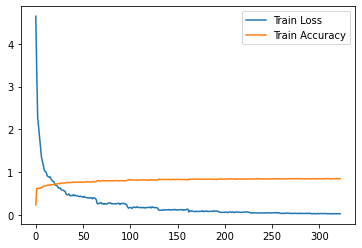

In [8]:
# 그래프로 loss 표기
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='Train Loss')
plt.plot(list_acc_loss, label='Train Accuracy')
plt.legend()
plt.show()

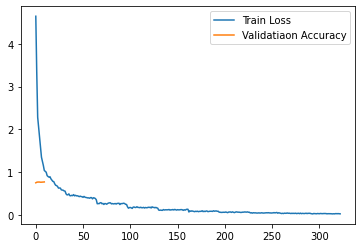

In [9]:
# train loss와 Validatiaon acc 출력
plt.plot(list_training_loss, label='Train Loss')
plt.plot(list_validation_acc_loss, label='Validatiaon Accuracy')
plt.legend()
plt.show()

In [11]:
### 전체모델 저장
os.makedirs(OUTPATH, exist_ok=True)
#torch.save(model, OUTPATH + 'pytorch_model.bin') 
model.save_pretrained(OUTPATH)  # save_pretrained 로 저장하면 config.json, pytorch_model.bin 2개의 파일이 생성됨

# tokeinizer 파일 저장(vocab)
VOCAB_PATH = OUTPATH
os.makedirs(VOCAB_PATH, exist_ok=True)
tokenizer.save_pretrained(VOCAB_PATH)

('../model/distibert/distilbert-fpt-wiki_20190620-mecab-model-0313-QA-0315/tokenizer_config.json',
 '../model/distibert/distilbert-fpt-wiki_20190620-mecab-model-0313-QA-0315/special_tokens_map.json',
 '../model/distibert/distilbert-fpt-wiki_20190620-mecab-model-0313-QA-0315/vocab.txt',
 '../model/distibert/distilbert-fpt-wiki_20190620-mecab-model-0313-QA-0315/added_tokens.json')